A/B/n Test: 

The purpose of this notebook is to test three variations of the checkout page to see if it increases the conversion rate. We collected data from users, who were randomly assigned to either groups.

## Imports 

In [32]:
# Add your code snippets here
import pandas as pd
import numpy as np 
import seaborn as sns
from scipy import stats
from scipy.stats import binom,chisquare
from matplotlib import pyplot as plt
from scipy.stats import norm
from statsmodels.stats.proportion import proportion_effectsize, proportions_ztest,proportion_confint
from statsmodels.stats import power
from statsmodels.stats.power import TTestIndPower
import pingouin

In [2]:
pd.set_option('display.max_columns', None)  

## Read Files

In [3]:
PATH = "datasets/"

In [4]:
check = pd.read_csv(PATH + 'checkout.csv')

## Exploration

### Checkout data 

In [5]:
check.head()

,Unnamed: 0,user_id,checkout_page,order_value,purchased,gender,browser,time_on_page
0,0,877621,A,29.410131,1.0,F,chrome,66.168628
1,1,876599,A,NaN,0.0,M,firefox,49.801887
2,2,905407,A,27.446845,1.0,M,chrome,56.744856
3,3,883562,A,30.602233,1.0,M,safari,71.890718
4,4,840542,A,29.668895,1.0,F,safari,67.410696


In [6]:
check.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     9000 non-null   int64  
 1   user_id        9000 non-null   int64  
 2   checkout_page  9000 non-null   object 
 3   order_value    7605 non-null   float64
 4   purchased      9000 non-null   float64
 5   gender         9000 non-null   object 
 6   browser        9000 non-null   object 
 7   time_on_page   9000 non-null   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 562.6+ KB


In [7]:
check.describe()

,Unnamed: 0,user_id,order_value,purchased,time_on_page
count,9000.000000,9000.000000,7605.000000,9000.000000,9000.000000
mean,4499.500000,874671.107778,30.009692,0.845000,43.205357
std,2598.220545,23152.083012,6.649486,0.361925,10.444232
min,0.000000,834528.000000,6.623576,0.000000,7.597721
25%,2249.750000,854533.750000,24.901830,1.000000,35.942253
50%,4499.500000,874657.500000,29.035593,1.000000,43.149846
75%,6749.250000,894669.500000,35.011926,1.000000,50.181631
max,8999.000000,914582.000000,51.968222,1.000000,83.051697


In [8]:
check.isna().sum()

Unnamed: 0          0
user_id             0
checkout_page       0
order_value      1395
purchased           0
gender              0
browser             0
time_on_page        0
dtype: int64

In [9]:
# double checking to see if when purchased is 0, then order value is null 
check.loc[check['purchased'] == 0, 'order_value'].isnull().all()


True

It seems all items that have not been ordered have a null order value 

In [10]:
# checking duplicates
duplicated = check.duplicated()
print("Duplicates : ", duplicated.value_counts())

Duplicates :  False    9000
dtype: int64


There are no duplicated values

In [11]:
# Unique users in each group 
users_group = check.groupby(['checkout_page'])['user_id'].nunique()

print('The number of users in each group: ',users_group)


The number of users in each group:  checkout_page
A    2940
B    2938
C    2954
Name: user_id, dtype: int64


In [12]:
# checkout page 
check['checkout_page'].value_counts(normalize = True )

A    0.333333
B    0.333333
C    0.333333
Name: checkout_page, dtype: float64

In [13]:
# gender
check['gender'].value_counts(normalize=True)

F    0.507556
M    0.492444
Name: gender, dtype: float64

In [14]:
check['browser'].value_counts(normalize=True)

safari     0.343333
chrome     0.331444
firefox    0.325222
Name: browser, dtype: float64

In [15]:
# how many in each group 
check.groupby('checkout_page')['gender'].value_counts(normalize = True)

checkout_page  gender
A              M         0.505000
               F         0.495000
B              F         0.507333
               M         0.492667
C              F         0.520333
               M         0.479667
Name: gender, dtype: float64

In [16]:
# Check the counts distribution of browsers across checkout pages
check.groupby('checkout_page')['browser'].value_counts(normalize = True)

checkout_page  browser
A              chrome     0.341333
               safari     0.332000
               firefox    0.326667
B              safari     0.352000
               firefox    0.325000
               chrome     0.323000
C              safari     0.346000
               chrome     0.330000
               firefox    0.324000
Name: browser, dtype: float64

All the data seems to be evenly distributed 

### Correlation exploration with numerical variables 

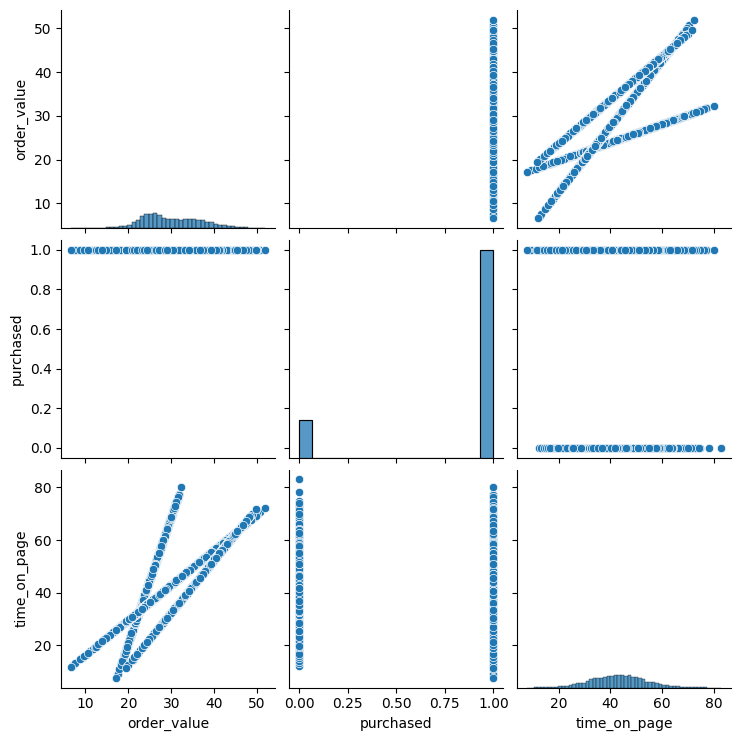

In [17]:
# correlations
sns.pairplot (check[['checkout_page','order_value','purchased','time_on_page']])

<AxesSubplot: >

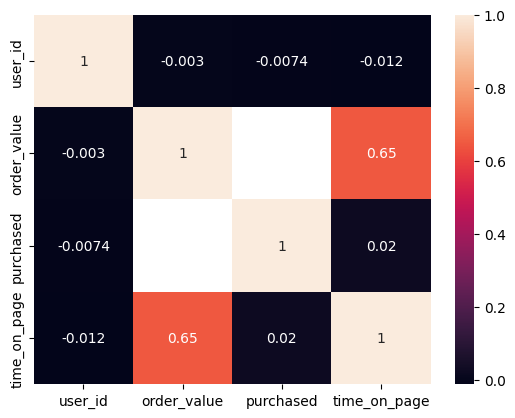

In [18]:
sns.heatmap(check[['user_id','order_value','purchased','time_on_page']].corr(), annot=True)

### Correlation exploration with categorical data 

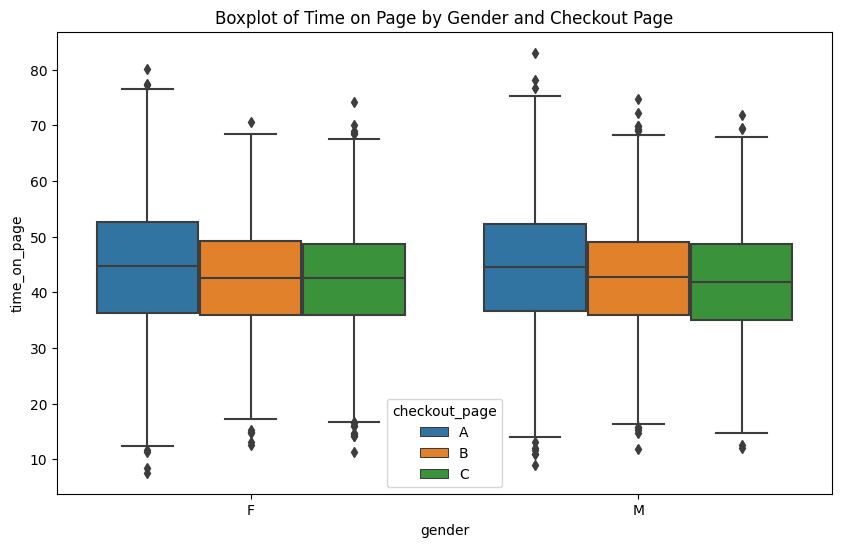

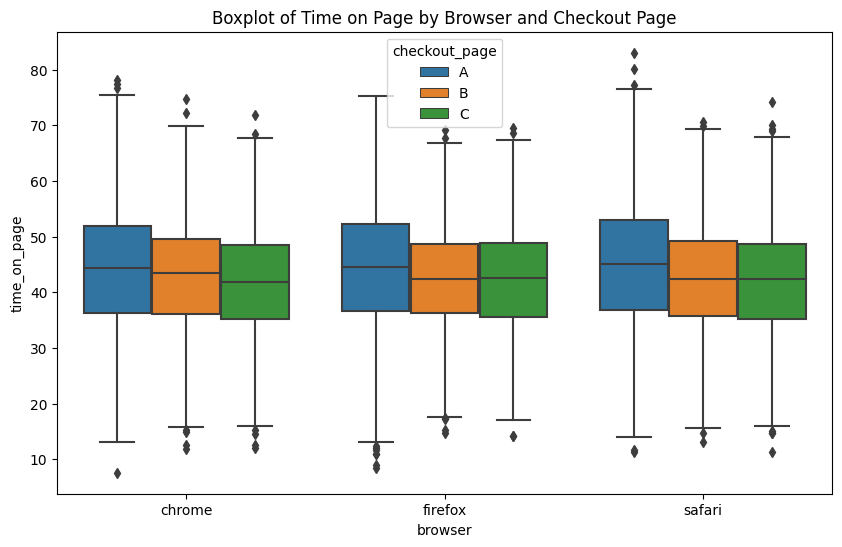

In [22]:

# Boxplot for gender and time_on_page
plt.figure(figsize=(10,6))
sns.boxplot(x='gender', y='time_on_page', hue='checkout_page', data=check)
plt.title('Boxplot of Time on Page by Gender and Checkout Page')
plt.show()

# Boxplot for browser and time_on_page
plt.figure(figsize=(10,6))
sns.boxplot(x='browser', y='time_on_page', hue='checkout_page', data=check)
plt.title('Boxplot of Time on Page by Browser and Checkout Page')
plt.show()


In [25]:
# Check the counts distribution of browsers across checkout pages
 # A '1' value in the purchased column corresponds to a user purchasing an item, and a '0' means they have abandoned the page without purchasing.
    
check.groupby(['checkout_page','browser'])['purchased'].value_counts(normalize = True)

checkout_page  browser  purchased
A              chrome   1.0          0.807617
                        0.0          0.192383
               firefox  1.0          0.829592
                        0.0          0.170408
               safari   1.0          0.824297
                        0.0          0.175703
B              chrome   1.0          0.830753
                        0.0          0.169247
               firefox  1.0          0.859487
                        0.0          0.140513
               safari   1.0          0.850379
                        0.0          0.149621
C              chrome   1.0          0.879798
                        0.0          0.120202
               firefox  1.0          0.866255
                        0.0          0.133745
               safari   1.0          0.857418
                        0.0          0.142582
Name: purchased, dtype: float64

### Basic Metrics 

In [24]:
# A '1' value in the purchased column corresponds to a user purchasing an item, and a '0' means they have abandoned the page without purchasing.
    
check.groupby('checkout_page')[['purchased', 'order_value']].agg(['mean','std','sum'])

purchased                   order_value                        
                   mean       std     sum        mean       std           sum
checkout_page                                                                
A              0.820333  0.383974  2461.0   24.956437  2.418837  61417.791564
B              0.847000  0.360048  2541.0   29.876202  7.277644  75915.430125
C              0.867667  0.338909  2603.0   34.917589  4.869816  90890.484142

Text(0, 0.5, 'Average Order Value ($)')

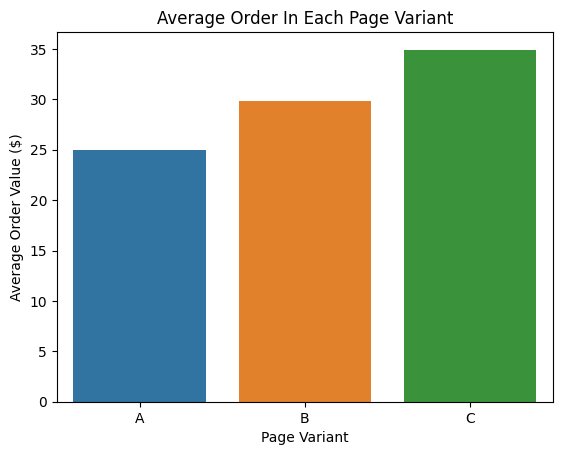

In [26]:
# average order in each checkout page variant 
sns.barplot(x = check['checkout_page'], y = check['order_value'], estimator=np.mean)
plt.title('Average Order In Each Page Variant')
plt.xlabel('Page Variant')
plt.ylabel('Average Order Value ($)')

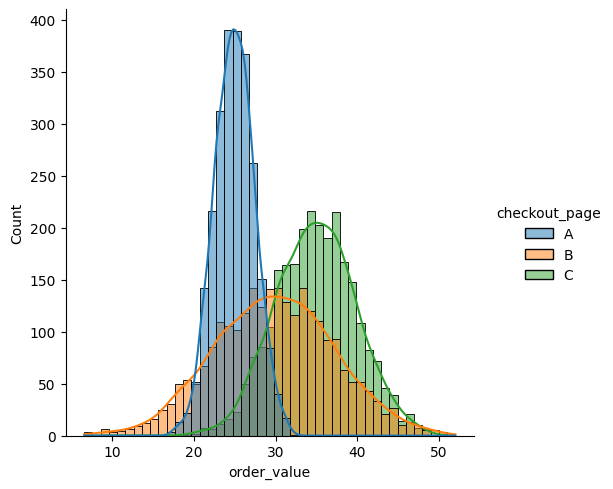

In [29]:
sns.displot(data = check, x='order_value',hue='checkout_page', kde=True)


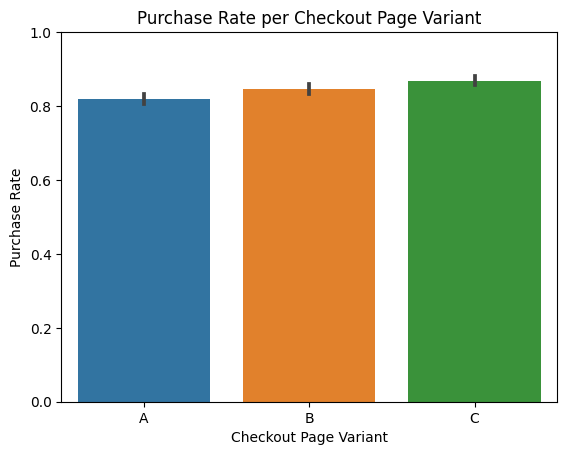

In [28]:
# Create a bar plot of average purchase rate per checkout page
sns.barplot(x=check['checkout_page'], y=check['purchased'], estimator=np.mean)
plt.ylim(0, 1)
plt.title('Purchase Rate per Checkout Page Variant')
plt.xlabel('Checkout Page Variant')
plt.ylabel('Purchase Rate')
plt.show()


Version C seems to have perfromed better in terms of average order and total orders 

# Hypothesis Testing

In [49]:
# baseline metrics 
# number of users in each group
n_a = check[check['checkout_page'] == "A"]['purchased'].count()
n_b = check[check['checkout_page'] == "B"]['purchased'].count()
n_c = check[check['checkout_page'] == "C"]['purchased'].count()

print ('Group A users :', n_a)
print ('Group B users :', n_b)
print ('Group C users :', n_c)

Group A users : 3000
Group B users : 3000
Group C users : 3000


In [36]:
# calculating the mean purchase rates 
m_a = check[check['checkout_page'] == "A"]['purchased'].mean()
m_b = check[check['checkout_page'] == "B"]['purchased'].mean()
m_c = check[check['checkout_page'] == "C"]['purchased'].mean()

print ('Group A mean purchases :', m_a)
print ('Group B mean purchases :', m_b)
print ('Group C mean purchases :', m_c)

Group A mean purchases : 0.8203333333333334
Group B mean purchases : 0.847
Group C mean purchases : 0.8676666666666667


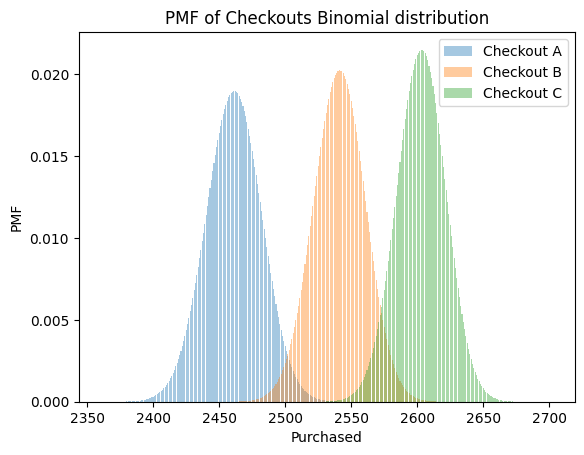

In [39]:
# looking at the binomial distribution 
# It models the number of successes in a fixed number of independent trials with a constant probability of success. (success rate )

x = np.arange(min(n_a*m_a, n_b*m_b, n_c*m_c) - 100, max(n_a*m_a, n_b*m_b, n_c*m_c) + 100)

binom_a = binom.pmf(x, n_a, m_a)
binom_b = binom.pmf(x, n_b, m_b)
binom_c = binom.pmf(x, n_c, m_c)

# Plot Binomial distributions A and B
plt.bar(x, binom_a, alpha=0.4, label='Checkout A') 
plt.bar(x, binom_b, alpha=0.4, label='Checkout B') 
plt.bar(x, binom_c, alpha=0.4, label='Checkout C') 

plt.xlabel ('Purchased') 
plt.ylabel ('PMF')
plt.legend()
plt.title('PMF of Checkouts Binomial distribution')
plt.show ()

These distributions tell us the probabilities of, at most, a certain number of users purchasing in each group, but they don't tell us anything about the long-term purchase probability of the overall population if we were to present either checkout page to the users.

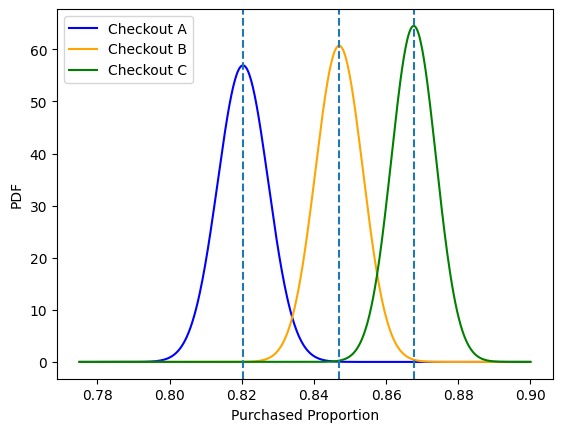

In [40]:
# probability density function to understand the spread of the data 
fig, ax = plt.subplots()

# Create x-axis range and normal distributions A, B and C
x = np.linspace(0.775, 0.9, 500)
norm_a = norm.pdf(x, m_a, np.sqrt(m_a * (1 - m_a) / n_a))
norm_b = norm.pdf(x, m_b, np.sqrt(m_b * (1 - m_b) / n_b))
norm_c = norm.pdf(x, m_c, np.sqrt(m_c * (1 - m_c) / n_c))

# Plot normal distributions A, B and C
sns.lineplot(x=x, y=norm_a, color='blue', ax=ax, label='Checkout A')
sns.lineplot(x=x, y=norm_b, color='orange', ax=ax, label='Checkout B')
sns.lineplot(x=x, y=norm_c, color='green', ax=ax, label='Checkout C')

# Add vertical lines
ax.axvline(m_a, linestyle='--')
ax.axvline(m_b, linestyle='--')
ax.axvline(m_c, linestyle='--')  # I'm assuming you want to add a line for p_C as well

ax.set_xlabel('Purchased Proportion')
ax.set_ylabel('PDF')
ax.legend(loc="upper left")
plt.show()


## Validating Testing Setup : Sanity Check

In [41]:
# Sample ratio mismatch : looking at the distribution of each group 
# testing the allocation of the users in each group 
group_a_per = users_group['A']/users_group.sum()
group_b_per = users_group['B']/users_group.sum()
group_c_per = users_group['C']/users_group.sum()
total_users = users_group.sum()

print('Percentage of users in group A', group_a_per)
print('Percentage of users in group B', group_b_per)
print('Percentage of users in group C', group_c_per)

obsereved = [users_group['A'],users_group['B'],users_group['C']]
expected = [total_users/3, total_users/3, total_users/3]

chi = chisquare(obsereved, f_exp = expected)

if(chi[1]<0.01): 
    print('SRM may be present')
else: 
    print('SRM not present')


Percentage of users in group A 0.3328804347826087
Percentage of users in group B 0.3326539855072464
Percentage of users in group C 0.3344655797101449
SRM not present


- In addition to this approach, A/A tests can be used before the actual A/B test
- After running the A/B test, consider novely effect(ctr or lift over time), explore new over existing users and only consider data after the plot stabalizes

In [43]:
# ztest delta : https://medium.com/@ahmadnuraziz3/applying-delta-method-for-a-b-tests-analysis-8b1d13411c22
# Delta method is one of the most practical A/B testing applications. As one encounters cases where the user assignment per variant is based on user_id to create a consistent experience, while the unit of analysis is something more granular such as a page view or a session.

#It is used to examine whether users have been fairly assigned to each group in your A/B/n test.
def var_delta(x,y): 
    x_bar = np.mean(x)
    y_bar = np.mean(y)
    x_var = np.var(x,ddof=1)
    y_var = np.var(y,ddof=1)
    cov_xy = np.cov(x,y,ddof=1)[0][1]    
    var_ratio = (x_var/y_bar**2 + y_var*(x_bar**2/y_bar**4) - 2*cov_xy*(x_bar/y_bar**3))/len(x)
    return var_ratio

# Delta method variance of ratio metric
def ztest_delta(x_control,y_control,x_treatment,y_treatment, alpha = 0.05):
    mean_control = x_control.sum()/y_control.sum()
    mean_treatment = x_treatment.sum()/y_treatment.sum()
    var_control = var_delta(x_control, y_control)
    var_treatment = var_delta(x_treatment, y_treatment)
    diff = mean_treatment - mean_control
    var = var_control + var_treatment
    # Calculate the two-tailed critical value
    cv = stats.norm.ppf(1-alpha/2)
    # Calculate the z_stat
    z_stat = diff/np.sqrt(var)
    # Calculate the p-value
    p_val = stats.norm.sf(abs(z_stat)) * 2.0
    # Calculate confidence intervals of the difference
    stde = cv*np.sqrt(var)
    lower = diff - stde 
    upper = diff + stde
    result = {'mean_control':mean_control,
              'mean_treatment':mean_treatment,
              'difference':round(diff, 3),
              'diff_CI':"["+str(round(lower,3))+", "+str(round(upper,3))+"]",
              'p-value':p_val}
    return result

# Create DataFrames for per user metrics for variants A and C
A_per_user = pd.DataFrame({'order_value':check[check['checkout_page']=='A'].groupby('user_id')['order_value'].sum() ,'page_view':check[check['checkout_page']=='A'].groupby('user_id')['user_id'].count()})

C_per_user = pd.DataFrame({'order_value':check[check['checkout_page']=='C'].groupby('user_id')['order_value'].sum(),'page_view':check[check['checkout_page']=='C'].groupby('user_id')['user_id'].count()})

# Assign the control and treatment ratio columns 
x_control = A_per_user['order_value']
y_control = A_per_user['page_view']
x_treatment = C_per_user['order_value']
y_treatment = C_per_user['page_view']


# Run a z-test for ratio metrics
ztest_delta(x_control,y_control,x_treatment,y_treatment)

{'mean_control': 20.472597188012,
 'mean_treatment': 30.29682804716834,
 'difference': 9.824,
 'diff_CI': '[9.25, 10.398]',
 'p-value': 1.5695484218904422e-246}

- The p-value is practically zero which means we can reject the null hypothesis that there is no difference
- On average, checkout page C is expected to generate about $10 more in order value per page view than checkout page A.
- These results suggest that checkout page C could be more effective at driving higher order values per page view than page A.
- 95% confident that the true average increase in order value per page view when a user is assigned to checkout page C rather than A lies somewhere between $9.25  and   $10.40.


## Setting up testing parameters 

In [48]:
# Calculate standardized effect size
effect_size_ab = proportion_effectsize(m_b,m_a) # use this only if using two variables 
effect_size_bc = proportion_effectsize(m_c, m_b)
effect_size_ac = proportion_effectsize(m_c, m_a)

print("Effect size A vs B: ", effect_size_ab)
print("Effect size B vs C: ", effect_size_bc)
print("Effect size A vs C: ", effect_size_ac)

Effect size A vs B:  0.07166382073486188
Effect size B vs C:  0.059128373266347456
Effect size A vs C:  0.13079219400120934


- An effect size of 0.07 between A and B indicates a small difference.
- The effect size of 0.06 between B and C is also small, even slightly smaller than between A and B.
- However, the effect size of 0.13 between A and C is larger, indicating a more substantial difference between these two groups.

In [50]:
# Calculate standardized sample size
power = 0.8

alpha = 0.05

test_power = TTestIndPower()

# Calculate sample sizes
sample_size_ab = test_power.solve_power(effect_size=effect_size_ab, power=power, alpha=alpha, nobs1=None )
sample_size_bc = test_power.solve_power(effect_size=effect_size_bc, power=power, alpha=alpha, nobs1=None)
sample_size_ac = test_power.solve_power(effect_size=effect_size_ac, power=power, alpha=alpha, nobs1=None)

print("Sample size A vs B: ", sample_size_ab)
print("Sample size B vs C: ", sample_size_bc)
print("Sample size A vs C: ", sample_size_ac)


Sample size A vs B:  3057.547194880926
Sample size B vs C:  4490.944128847193
Sample size A vs C:  918.6026749789224


# A/B/n Test

In [51]:
# the number of users 
users_a = users_group['A']
users_b = users_group['B']
users_c = users_group['C']

# number of users who made atleast one purchase 
purchased_a = check[check['checkout_page']=='A'].groupby('user_id')['purchased'].max().sum()
purchased_b = check[check['checkout_page']=='B'].groupby('user_id')['purchased'].max().sum()
purchased_c = check[check['checkout_page']=='C'].groupby('user_id')['purchased'].max().sum()

In [52]:
# conducting multiple tests to compare each pair of versions (A vs B, B vs C, A vs C).
ab_test = [purchased_a,purchased_b]
n_ab = [users_a,users_b]

bc_test =[purchased_b,purchased_c]
n_bc = [users_b, users_c]

ac_test = [purchased_a, purchased_c]
n_ac = [users_a,users_c]

In [53]:
# AB
# Calculate p-value and confidence intervals
z_stat, pvalue = proportions_ztest (ab_test, nobs=n_ab)
(A_lo95, B_lo95), (A_up95, B_up95) = proportion_confint(ab_test, nobs=n_ab, alpha=0.05)

print (f'p-value: {pvalue: .4f}')
print (f'Group A 95% CI : [{A_lo95:.47}, {A_up95:.4f}]') 
print (f'Group B 95% CI : [{B_lo95:.4f}, {B_up95:.4f}]')

if pvalue < 0.05: 
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

p-value:  0.0058
Group A 95% CI : [0.8072340073631821821820153672888409346342086792, 0.8349]
Group B 95% CI : [0.8349, 0.8608]
Reject the null hypothesis


In [54]:
# BC
# Calculate p-value and confidence intervals
z_stat, pvalue = proportions_ztest (bc_test, nobs=n_bc)
(B_lo95, C_lo95), (B_up95, C_up95) = proportion_confint(bc_test, nobs=n_bc, alpha=0.05)

print (f'p-value: {pvalue: .4f}')
print (f'Group B 95% CI : [{B_lo95:.47}, {B_up95:.4f}]') 
print (f'Group c 95% CI : [{C_lo95:.4f}, {C_up95:.4f}]')

if pvalue < 0.05: 
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

p-value:  0.0162
Group B 95% CI : [0.83486861869032569227755402607726864516735076904, 0.8608]
Group c 95% CI : [0.8575, 0.8818]
Reject the null hypothesis


In [55]:
# AC
# Calculate p-value and confidence intervals
z_stat, pvalue = proportions_ztest (ac_test, nobs=n_ac)
(A_lo95, C_lo95), (A_up95, C_up95) = proportion_confint(ac_test, nobs=n_ac, alpha=0.05)

print (f'p-value: {pvalue: .4f}')
print (f'Group A 95% CI : [{A_lo95:.47}, {A_up95:.4f}]') 
print (f'Group c 95% CI : [{C_lo95:.4f}, {C_up95:.4f}]')

if pvalue < 0.05: 
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

p-value:  0.0000
Group A 95% CI : [0.8072340073631821821820153672888409346342086792, 0.8349]
Group c 95% CI : [0.8575, 0.8818]
Reject the null hypothesis


Confidence intervals give us the long-term probability that a range of plausible values would cover the population mean.

- With all these tests, we reject that they have similar purchase rates


- From the confidence intervals, you can see that there is no overlap between the intervals for Group A and Group C, and the overlap between Group A and Group B, and Group B and Group C is minimal. This lack of overlap reinforces the conclusion from the z-tests that the differences in purchase rates between the groups are statistically significant.


- The direction of the differences is also clear. Group C has the highest purchase rate, followed by Group B, and then Group A. This suggests that whatever changes were made in the checkout page for Group C were the most effective in increasing purchases, followed by the changes for Group B.


## Comparing all the pages at once 

In [56]:
pairwise = pingouin.pairwise_tests(data=check, dv='purchased', between='checkout_page', padjust='bonf')

for i in pairwise.iterrows(): 
    
    if i[1]['p-unc'] < 0.05: 
        print('Reject the null hypothesis between groups ', i[1]['A'], i[1]['B'])
    else:
        print('Fail to reject the null hypothesis between groups ', i[1]['A'], i[1]['B'])



Reject the null hypothesis between groups  A B
Reject the null hypothesis between groups  A C
Reject the null hypothesis between groups  B C


# Additional exploration

Zooming in on other attributes:
- Time On Page


In [57]:
time_spent = check.groupby('checkout_page')['time_on_page'].mean()
print(time_spent)

checkout_page
A    44.668527
B    42.723772
C    42.223772
Name: time_on_page, dtype: float64


In [58]:
ttest_ =  pingouin.ttest(x=check[check['checkout_page']=='B']['time_on_page'], \
               y= check[check['checkout_page']=='C']['time_on_page'],\
            paired = False, alternative = "two-sided")

print(ttest_.transpose())


                   T-test
T                1.995423
dof                  5998
alternative     two-sided
p-val            0.046042
CI95%        [0.01, 0.99]
cohen-d          0.051522
BF10                0.212
power            0.514054


The proximity of the p-value to 5% and the lower bound of the confidence interval being close to 0 suggests that options B or C could potentially be implemented. However, previous tests strongly favor the selection of page C.

Notes : if the distribution was not normal, an alternative would have been to run a Mann-Whitney U test, or a Chi Sqaure test (non-parametric)


Version C is the one to choose!